## Applying kBET to CFReT data
In this notebook, we use the k-nearest neighbour Batch Effect Test ([kBET](https://www.nature.com/articles/s41592-018-0254-1)) to evaluate whether there are significant batch effects or technical variations between plates in our dataset. Specifically, our experimental design includes one primary batch composed of four plates, each serving as technical replicates containing the same set of 50 compounds.

kBET assesses whether different batches or technical groups (such as plates) are well-mixed in a batch by examining the local distribution of labels in a high-dimensional feature space. If the distribution of plate labels within each sample's nearest neighbors closely matches the overall plate distribution, kBET concludes that technical variation is minimal. Conversely, significant differences indicate the presence of substantial batch or technical effects. By applying kBET, we can quantify and visualize how evenly mixed our replicate plates are, ensuring the quality and reproducibility of our experimental results.

In [1]:
suppressMessages(library(RCurl)) # for downloading files
suppressMessages(library(dplyr)) # data manipulation
suppressMessages(library(gridExtra)) # for arranging plots
suppressMessages(library(ggplot2)) # plotting
suppressMessages(library(kBET)) # kBET package
suppressMessages(library(data.table)) # loading csv files

In [2]:
# set data path. raise error if the data path is not found
data_path <- file.path("../UMAP-aggregated-fs-profiles/results/concat_data/batch_1_concat_agg_fs.csv")
if (!file.exists(data_path)) {
  stop("The data path does not exist.")
}

# setting output path for plots and figures
output_path <- file.path("results/figures")
if (!dir.exists(output_path)) {
  dir.create(output_path, recursive = TRUE)
}

In [3]:
# Load the aggregated feature profiles data from the specified path
agg_fs_profiles_df <- fread(data_path)

# Split the columns into metadata and morphology feature dataframes
# Metadata columns start with "Metadata_"
metadata_df <- agg_fs_profiles_df %>% select(starts_with("Metadata_"))

# Morphology feature columns do not start with "Metadata_"
morphology_df <- agg_fs_profiles_df %>% select(-starts_with("Metadata_"))

In [4]:
# execute kBET
set.seed(0)
batch.estimate <- kBET(morphology_df, metadata_df$Metadata_plate_barcode, n_repeat = 1000, plot=FALSE)

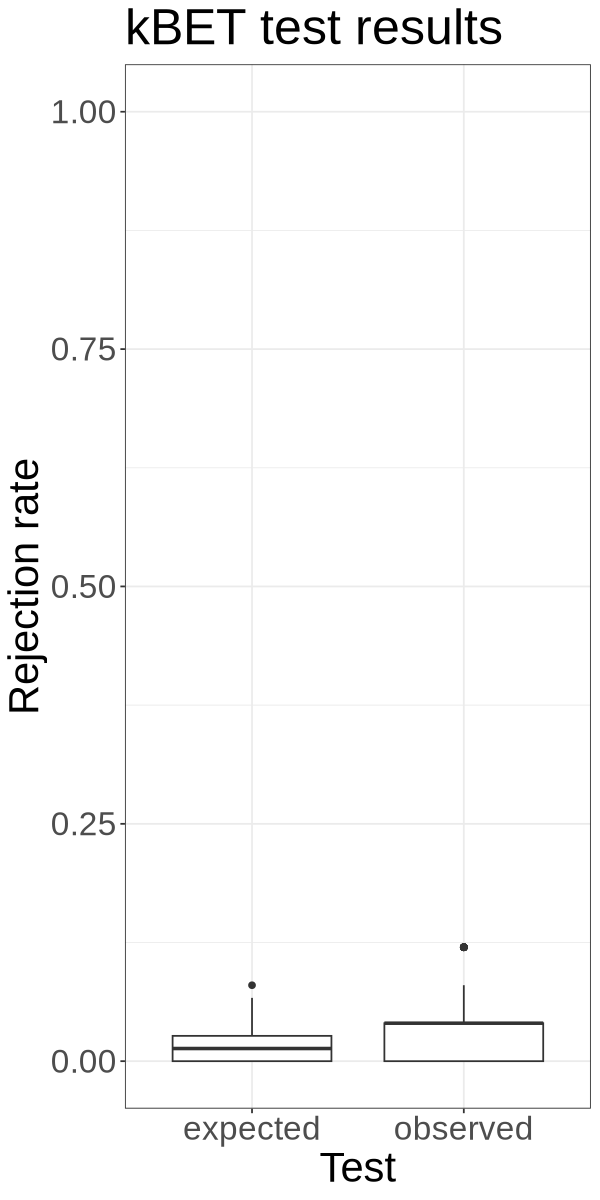

In [5]:
# size of plot in notebooks
options(repr.plot.width=5, repr.plot.height=10)

# collecting kBET values for plotting
plot.data <- data.frame(class=rep(c('observed', 'expected'), 
                                  each=length(batch.estimate$stats$kBET.observed)), 
                        data =  c(batch.estimate$stats$kBET.observed,
                                  batch.estimate$stats$kBET.expected))
# plot the kbet results 
kbet_results_plot <- ggplot(plot.data, aes(class, data)) + geom_boxplot() + 
     labs(x='Test', y='Rejection rate',title='kBET test results') +
     theme_bw() +  
     theme(text = element_text(size=25)) +
     scale_y_continuous(limits=c(0,1))


kbet_results_plot

# save the plot
ggsave(file.path(output_path, "kbet_results_plot.png"), kbet_results_plot, width = 5, height = 10, units = "in", dpi = 300)

In [6]:
# obtaining summary table
kbet_summary <- batch.estimate$summary

# update the column names for the summary table
colnames(kbet_summary) <- c("kBET (null)", "kBET", "p-value")

# save the summary table as csv
write.csv(kbet_summary, file.path(output_path, "kbet_summary.csv"), row.names = FALSE)

# display trable
kbet_summary

,kBET (null),kBET,p-value
,<dbl>,<dbl>,<dbl>
mean,0.01549333,0.02792,0.614616753
2.5%,0.00000000,0.00000,0.002542588
50%,0.01333333,0.04000,0.590818968
97.5%,0.05333333,0.08000,1.000000000
